In [10]:
import vrep
import time
import numpy as np
from numpy import cos
from numpy import sin
from copy import copy

# for plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
num_legs = 6

step_radius = 0.04
step_height = 0.03
x_offset = 0.00
y_offset = -0.11
z_offset = -0.08

num_top_points = 16
num_bot_points = 20
num_pts = num_top_points + num_bot_points

In [27]:
# helper rotation matrix functions
# def R_z(k,vector):
#      phi = -np.pi/3
#      rotm = np.array([[cos(k*phi),sin(k*phi),0],[-sin(k*phi),cos(k*phi),0],[0,0,1]])
#      return np.transpose(np.matmul(rotm,np.transpose(vector)))
def R_z(phi,vector):
    rotm = np.array([[cos(phi),sin(phi),0],[-sin(phi),cos(phi),0],[0,0,1]])
    return np.transpose(np.matmul(rotm,np.transpose(vector)))
def rotate_step_path(phi,sp_given):
    for j in range(len(sp_given[0,:])):
        sp_roted = np.transpose(np.array([R_z(phi,l) for l in np.transpose(sp_given)]))
    return sp_roted

def leg_IK(pos):
    x = pos[0]
    y = pos[1]
    z = pos[2]

    Y4 = 0.11651167932822327
    Z4 = 0
    Y2 = 0.05149697649731044
    Y3 = 0.07238155732083357

    le = np.sqrt(Y4*Y4+Z4*Z4)
    
    theta1 = np.arctan(x/np.abs(y))
    L1 = np.sqrt(x*x+y*y)
    L2 = (L1-Y2)*(L1-Y2)
    L = np.sqrt(z*z+L2)
    alpha1 = np.abs(np.arctan((L1-Y2)/z))
    alpha2 = np.arccos((L*L+Y3*Y3-le*le)/(2*L*Y3))
    theta2 = alpha1+alpha2-np.pi/2
    beta = np.arccos((le*le+Y3*Y3-L*L)/(2*le*Y3))
    gamma = np.arctan(Z4/Y4)
    theta3 = beta-gamma
    return [theta1,-theta2,theta3*2]

# Setup the thetas used for the upper arc-section of the step
theta = np.linspace(np.pi,0,num_top_points+2)[1:-1]
# Setup the x,y,z coordinates of the foot path sections
x = step_radius*np.linspace(1,-1,num_bot_points)
x = np.append(x,step_radius*cos(theta))
z = np.zeros(num_bot_points)
z = np.append(z,step_height*sin(theta))
y = np.zeros(num_bot_points+num_top_points)
# Put them all together
step_path = np.array([x,y,z])

# Create empty array of step paths
step_paths = np.zeros([num_legs,3,num_pts])
joint_angles = np.zeros([num_legs,3,num_pts])

# Fill array of step paths through shifting and rotating
step_paths[0,:,:] = step_path
for i in range(num_legs-1):
    rollby = (i+1)%2*int(num_pts/2)
    step_paths[i+1,:,:] = np.roll(rotate_step_path(-(i+1)*np.pi/3,step_path),rollby,axis=1)

# Translate all the steps + Make joint angle matrix
for i in range(num_legs):
    for j in range(num_pts):
        step_paths[i,:,j] = step_paths[i,:,j]+np.array([x_offset,y_offset,z_offset])
        joint_angles[i,:,j] = leg_IK(step_paths[i,:,j])

# Return those juicy sexy lovely joint angles
# joint_angles
step_paths[0,:,:]

array([[ 0.04      ,  0.03578947,  0.03157895,  0.02736842,  0.02315789,
         0.01894737,  0.01473684,  0.01052632,  0.00631579,  0.00210526,
        -0.00210526, -0.00631579, -0.01052632, -0.01473684, -0.01894737,
        -0.02315789, -0.02736842, -0.03157895, -0.03578947, -0.04      ,
        -0.03931892, -0.03729889, -0.03400869, -0.02956036, -0.02410539,
        -0.01782953, -0.01094652, -0.00369073,  0.00369073,  0.01094652,
         0.01782953,  0.02410539,  0.02956036,  0.03400869,  0.03729889,
         0.03931892],
       [-0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11   

<IPython.core.display.Javascript object>


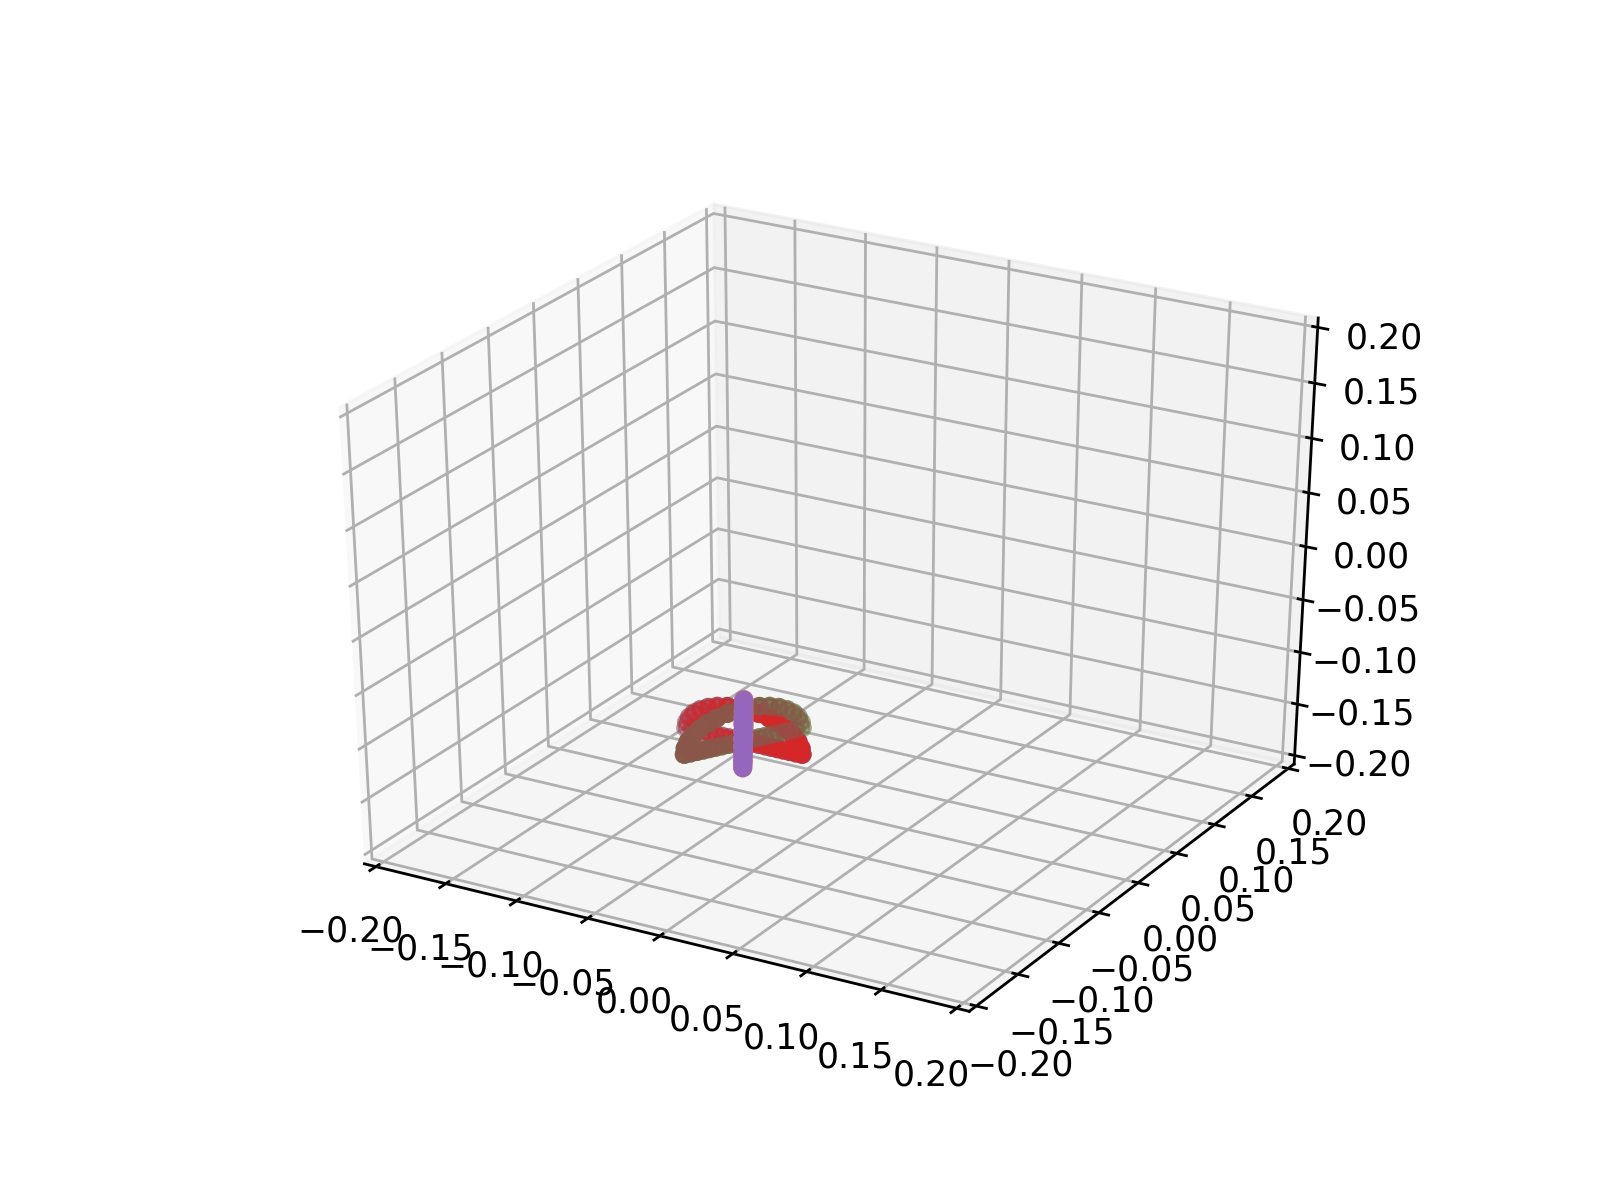

In [28]:
cir_the = np.linspace(0,2*np.pi,60)
circle = np.array([step_radius*cos(cir_the),step_radius*sin(cir_the),np.zeros(60)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-.2,.2)
ax.set_ylim(-.2,.2)
ax.set_zlim(-.2,.2)
ax.scatter(step_paths[0,0,:],step_paths[0,1,:],step_paths[0,2,:])
ax.scatter(step_paths[1,0,:],step_paths[1,1,:],step_paths[1,2,:])
ax.scatter(step_paths[2,0,:],step_paths[2,1,:],step_paths[2,2,:])
ax.scatter(step_paths[3,0,:],step_paths[3,1,:],step_paths[3,2,:])
ax.scatter(step_paths[4,0,:],step_paths[4,1,:],step_paths[4,2,:])
ax.scatter(step_paths[5,0,:],step_paths[5,1,:],step_paths[5,2,:])

# ax.plot(circle[0,:],circle[1,:],circle[2,:])



In [17]:
step_paths[0,:,:]

array([[-0.04      , -0.03578947, -0.03157895, -0.02736842, -0.02315789,
        -0.01894737, -0.01473684, -0.01052632, -0.00631579, -0.00210526,
         0.00210526,  0.00631579,  0.01052632,  0.01473684,  0.01894737,
         0.02315789,  0.02736842,  0.03157895,  0.03578947,  0.04      ,
        -0.03931892, -0.03729889, -0.03400869, -0.02956036, -0.02410539,
        -0.01782953, -0.01094652, -0.00369073,  0.00369073,  0.01094652,
         0.01782953,  0.02410539,  0.02956036,  0.03400869,  0.03729889,
         0.03931892],
       [-0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11      , -0.11      , -0.11      , -0.11      ,
        -0.11      , -0.11   

In [20]:
np.roll(a,2)

NameError: name 'a' is not defined

In [49]:
np.ones([6,3,10])

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [53]:
print(0%2)
print(1%2)
print(2%2)
print(3%2)
print(4%2)

0
1
0
1
0


In [56]:
len(step_path[0,:])

36

[[-4.00000000e-02 -3.57894737e-02 -3.15789474e-02 -2.73684211e-02
  -2.31578947e-02 -1.89473684e-02 -1.47368421e-02 -1.05263158e-02
  -6.31578947e-03 -2.10526316e-03  2.10526316e-03  6.31578947e-03
   1.05263158e-02  1.47368421e-02  1.89473684e-02  2.31578947e-02
   2.73684211e-02  3.15789474e-02  3.57894737e-02  4.00000000e-02
  -3.93189240e-02 -3.72988892e-02 -3.40086854e-02 -2.95603567e-02
  -2.41053855e-02 -1.78295342e-02 -1.09465196e-02 -3.69073438e-03
   3.69073438e-03  1.09465196e-02  1.78295342e-02  2.41053855e-02
   2.95603567e-02  3.40086854e-02  3.72988892e-02  3.93189240e-02]
 [-5.87830464e-17 -5.25953573e-17 -4.64076682e-17 -4.02199791e-17
  -3.40322900e-17 -2.78446009e-17 -2.16569118e-17 -1.54692227e-17
  -9.28153364e-18 -3.09384455e-18  3.09384455e-18  9.28153364e-18
   1.54692227e-17  2.16569118e-17  2.78446009e-17  3.40322900e-17
   4.02199791e-17  4.64076682e-17  5.25953573e-17  5.87830464e-17
  -5.77821533e-17 -5.48135583e-17 -4.99783533e-17 -4.34411954e-17
  -3.5424